# **Part 0: Install dependencies** 

In [1]:
# === Part 0: Install dependencies (Lightly) ===
!pip -q install lightly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Part 1 — Setup & Config

In [2]:
# === Part 1: Setup & Config ===
import os, math, random, numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Lightly (for SimCLR pretraining option) ----
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

# -----------------------
# User toggles
# -----------------------
ENHANCED = False            # set True to try safe boosts (recommended to try later)
USE_LIGHTLY_SIMCLR = True   # <- set True to use Lightly SimCLR pretraining you provided
DATA_DIR = '/kaggle/input/riceds-original/Original'
SAVE_DIR = './'
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
NUM_WORKERS = 4
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# SimCLR pretrain (shared)
SIMCLR_EPOCHS = 100          # try 200–400 if you can afford it
SIMCLR_LR = 3e-4
SIMCLR_WEIGHT_DECAY = 1e-6
TEMPERATURE = 0.2

# Supervised fine-tune (NO FREEZING)
FINETUNE_EPOCHS = 30
FT_LR_BACKBONE = 1e-4        # lower LR for encoder
FT_LR_HEAD = 1e-3            # higher LR for classifier head
FT_WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.0           # if using MixUp, keep 0 or very small

USE_IMAGENET_WEIGHTS = True
USE_EMA = True               # EMA of fine-tune weights
EMA_DECAY = 0.999
USE_MIXUP = True
MIXUP_ALPHA = 0.2
USE_TTA = True               # eval-time flip TTA

# Enhancements (only used if ENHANCED=True)
WARMUP_RATIO = 0.1           # 10% warmup
USE_BALANCED_SAMPLER = True  # class-balanced sampler for FT
TRACK_BN_IN_EMA = True       # include BN running stats in EMA
RUN_KNN_EVAL = True          # quick SSL sanity check

# Histories for curves
simclr_loss_hist, ft_loss_hist, ft_acc_hist, val_acc_hist = [], [], [], []

# Reproducibility
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
import torch.backends.cudnn as cudnn
cudnn.deterministic = True; cudnn.benchmark = False

print("Device:", DEVICE)
print("Enhanced mode:", ENHANCED)
print("Using Lightly for SimCLR pretraining:", USE_LIGHTLY_SIMCLR)


Device: cuda
Enhanced mode: False
Using Lightly for SimCLR pretraining: True


# Part 2 — Augmentations

In [3]:
# === Part 2: Augmentations ===
# SimCLR two-crop transform (native)
class TwoCropsTransform:
    """Return two random augmentations of the same image (SimCLR)."""
    def __init__(self, size=224, enhanced=False):
        normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
        if enhanced:
            # scale blur kernel to image size
            k = int(size * 0.07) // 2 * 2 + 1  # ~7% of size, odd
        else:
            k = 9
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=k, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            normalize,
        ])
    def __call__(self, x):
        return self.transform(x), self.transform(x)

# Supervised transforms
supervised_train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


# Part 3 — Stratified Split (80/20)

In [4]:
# === Part 3: Stratified 80/20 split BEFORE training ===
_from_split = datasets.ImageFolder(DATA_DIR, transform=transforms.ToTensor())
labels_all = [lbl for _, lbl in _from_split.samples]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(sss.split(np.zeros(len(labels_all)), labels_all))

len_train, len_test = len(train_idx), len(test_idx)
print(f"Train size: {len_train}, Test size: {len_test}, Classes: {len(_from_split.classes)}")


Train size: 15200, Test size: 3800, Classes: 38


# Part 4 — SSL Datasets & Loaders

In [5]:
# === Part 4: SSL datasets/loaders with SAME indices ===
if USE_LIGHTLY_SIMCLR:
    # Lightly's SimCLRTransform returns two crops as a tuple
    ssl_dataset = datasets.ImageFolder(
        DATA_DIR,
        transform=SimCLRTransform(input_size=224, gaussian_blur=1.0)  # blur on for 224
    )
else:
    ssl_dataset = datasets.ImageFolder(
        DATA_DIR,
        transform=TwoCropsTransform(enhanced=ENHANCED)
    )

train_ssl = Subset(ssl_dataset, train_idx)

train_loader_ssl = DataLoader(
    train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,                 # BN stability
    num_workers=NUM_WORKERS,
    pin_memory=True
)


# Part 5 — Models (Encoder, Projector, Sup Head) + Losses

In [6]:
# === Part 5: Models & Losses ===
class Encoder(nn.Module):
    def __init__(self, use_imagenet=True):
        super().__init__()
        if use_imagenet:
            try:
                base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            except Exception:
                base = models.resnet50(pretrained=True)
        else:
            base = models.resnet50(weights=None)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # (B, 2048, 1, 1)
        self.feature_dim = 2048
    def forward(self, x):
        x = self.backbone(x)
        return torch.flatten(x, 1)                                   # (B, 2048)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, bn_last=False):
        super().__init__()
        layers = [
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim),
        ]
        if bn_last:
            layers.append(nn.BatchNorm1d(out_dim, affine=False))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Native SimCLR (your original)
class SimCLR_Native(nn.Module):
    def __init__(self, encoder, proj_dim=256, hidden=2048):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(encoder.feature_dim, hidden, proj_dim, bn_last=True)
    def forward(self, x1, x2):
        h1 = self.encoder(x1); h2 = self.encoder(x2)
        z1 = self.projector(h1); z2 = self.projector(h2)
        return z1, z2

# Lightly-style SimCLR (uses Lightly's projection head and loss)
class SimCLR_Lightly(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder                  # same resnet50 backbone encoder
        self.projection_head = SimCLRProjectionHead(encoder.feature_dim, 512, 128)
    def forward_single(self, x):
        h = self.encoder(x)                     # (B, 2048)
        z = self.projection_head(h)
        return z
    def forward(self, x1, x2):
        return self.forward_single(x1), self.forward_single(x2)

# InfoNCE (native). Kept for native branch
def nt_xent_loss_native(z1, z2, temperature=0.2):
    b = z1.size(0)
    z1 = F.normalize(z1, dim=1).float()
    z2 = F.normalize(z2, dim=1).float()
    z  = torch.cat([z1, z2], dim=0)                 # (2B, d)
    logits = z @ z.t() / float(temperature)         # (2B, 2B)
    eye = torch.eye(2*b, device=z.device, dtype=torch.bool)
    logits.masked_fill_(eye, -1e9)                  # remove self
    targets = (torch.arange(2*b, device=z.device) + b) % (2*b)
    return F.cross_entropy(logits, targets)

# Supervised model
class SupModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(encoder.feature_dim, num_classes)
    def forward(self, x):
        feats = self.encoder(x)                      # (B, 2048)
        return self.head(feats)


# Part 6 — SimCLR Pretraining (Native or Lightly)

In [7]:
# === Part 6: SimCLR Pretraining (Native OR Lightly) ===
# This cell saves encoder weights to enc_path; downstream parts remain unchanged.
enc_path = os.path.join(SAVE_DIR, "simclr_encoder.pth")

if USE_LIGHTLY_SIMCLR:
    # ----- Lightly branch (implements your provided example at 224px / ResNet50) -----
    encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
    simclr = SimCLR_Lightly(encoder).to(DEVICE)

    # Lightly's NTXentLoss
    criterion = NTXentLoss(temperature=TEMPERATURE)

    # Optimizer (use AdamW like your setup; feel free to try SGD lr=0.06 if you want to mirror the example)
    optimizer = torch.optim.AdamW(simclr.parameters(), lr=SIMCLR_LR, weight_decay=SIMCLR_WEIGHT_DECAY)

    # Optional warmup for enhanced mode
    def cosine_with_warmup(optim, warmup_steps, total_steps):
        def lr_lambda(step):
            if step < warmup_steps: return step / max(1, warmup_steps)
            progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
        return torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

    if ENHANCED:
        total_steps = SIMCLR_EPOCHS * len(train_loader_ssl)
        warmup_steps = int(WARMUP_RATIO * total_steps)
        sched = cosine_with_warmup(optimizer, warmup_steps, total_steps)
    else:
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SIMCLR_EPOCHS * len(train_loader_ssl))

    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

    print("Starting Lightly SimCLR pretraining")
    for epoch in range(SIMCLR_EPOCHS):
        simclr.train()
        total_loss = 0.0
        pbar = tqdm(train_loader_ssl, desc=f"Lightly SimCLR {epoch+1}/{SIMCLR_EPOCHS}")
        for i, batch in enumerate(pbar, start=1):
            # Lightly's SimCLRTransform returns a tuple (x0, x1) as batch[0]
            if isinstance(batch[0], (tuple, list)) and len(batch[0]) == 2:
                x0, x1 = batch[0]
            else:
                # fallback if transform behaved differently
                (x0, x1), _ = batch
            x0 = x0.to(DEVICE, non_blocking=True)
            x1 = x1.to(DEVICE, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
                z0 = simclr.forward_single(x0)
                z1 = simclr.forward_single(x1)
                loss = criterion(z0, z1)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += float(loss.detach().item())
            if ENHANCED:
                sched.step()
            else:
                # step-per-iteration cosine to mimic flat+cos behavior
                sched.step()

            pbar.set_postfix(loss=f"{total_loss/i:.4f}")

        epoch_loss = total_loss / len(train_loader_ssl)
        simclr_loss_hist.append(epoch_loss)
        print(f"Lightly SimCLR Epoch {epoch+1}: loss={epoch_loss:.4f}")

    # Save encoder after Lightly SimCLR pretrain
    torch.save(simclr.encoder.state_dict(), enc_path)
    print(f"Saved SimCLR encoder to: {enc_path}")

else:
    # ----- Native branch (your original SimCLR) -----
    encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
    simclr = SimCLR_Native(encoder).to(DEVICE)

    ssl_optimizer = torch.optim.AdamW(simclr.parameters(), lr=SIMCLR_LR, weight_decay=SIMCLR_WEIGHT_DECAY)
    ssl_sched = torch.optim.lr_scheduler.CosineAnnealingLR(ssl_optimizer, T_max=SIMCLR_EPOCHS)

    # Optional warmup
    def cosine_with_warmup(optimizer, warmup_steps, total_steps):
        def lr_lambda(step):
            if step < warmup_steps:
                return step / max(1, warmup_steps)
            progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    if ENHANCED:
        total_steps = SIMCLR_EPOCHS * len(train_loader_ssl)
        warmup_steps = int(WARMUP_RATIO * total_steps)
        ssl_sched = cosine_with_warmup(ssl_optimizer, warmup_steps, total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

    for epoch in range(SIMCLR_EPOCHS):
        simclr.train()
        running = 0.0
        pbar = tqdm(train_loader_ssl, desc=f"SimCLR Epoch {epoch+1}/{SIMCLR_EPOCHS}")
        for i, ((v1, v2), _) in enumerate(pbar, start=1):
            x1 = v1.to(DEVICE, non_blocking=True)
            x2 = v2.to(DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
                z1, z2 = simclr(x1, x2)
                loss = nt_xent_loss_native(z1, z2, temperature=TEMPERATURE)
            ssl_optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(ssl_optimizer)
            scaler.update()
            running += loss.item()
            pbar.set_postfix(loss=f"{running / i:.4f}")

        epoch_loss = running / len(train_loader_ssl)
        simclr_loss_hist.append(epoch_loss)
        ssl_sched.step()
        print(f"SimCLR Epoch {epoch+1}: loss={epoch_loss:.4f}")

    # Save encoder after native SimCLR pretrain
    torch.save(simclr.encoder.state_dict(), enc_path)
    print(f"Saved SimCLR encoder to: {enc_path}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]
/tmp/ipykernel_18/3653151965.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))


Starting Lightly SimCLR pretraining


Lightly SimCLR 1/100:   0%|          | 0/237 [00:00<?, ?it/s]/tmp/ipykernel_18/3653151965.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Lightly SimCLR 1/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=2.6902]


Lightly SimCLR Epoch 1: loss=2.6902


Lightly SimCLR 2/100: 100%|██████████| 237/237 [02:35<00:00,  1.53it/s, loss=1.9379]


Lightly SimCLR Epoch 2: loss=1.9379


Lightly SimCLR 3/100: 100%|██████████| 237/237 [02:35<00:00,  1.52it/s, loss=1.7788]


Lightly SimCLR Epoch 3: loss=1.7788


Lightly SimCLR 4/100: 100%|██████████| 237/237 [02:38<00:00,  1.50it/s, loss=1.6838]


Lightly SimCLR Epoch 4: loss=1.6838


Lightly SimCLR 5/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.6208]


Lightly SimCLR Epoch 5: loss=1.6208


Lightly SimCLR 6/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.5770]


Lightly SimCLR Epoch 6: loss=1.5770


Lightly SimCLR 7/100: 100%|██████████| 237/237 [02:35<00:00,  1.52it/s, loss=1.5373]


Lightly SimCLR Epoch 7: loss=1.5373


Lightly SimCLR 8/100: 100%|██████████| 237/237 [02:35<00:00,  1.52it/s, loss=1.5199]


Lightly SimCLR Epoch 8: loss=1.5199


Lightly SimCLR 9/100: 100%|██████████| 237/237 [02:35<00:00,  1.52it/s, loss=1.4988]


Lightly SimCLR Epoch 9: loss=1.4988


Lightly SimCLR 10/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.4496]


Lightly SimCLR Epoch 10: loss=1.4496


Lightly SimCLR 11/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.4440]


Lightly SimCLR Epoch 11: loss=1.4440


Lightly SimCLR 12/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.4284]


Lightly SimCLR Epoch 12: loss=1.4284


Lightly SimCLR 13/100: 100%|██████████| 237/237 [02:35<00:00,  1.52it/s, loss=1.4237]


Lightly SimCLR Epoch 13: loss=1.4237


Lightly SimCLR 14/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.4148]


Lightly SimCLR Epoch 14: loss=1.4148


Lightly SimCLR 15/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.4063]


Lightly SimCLR Epoch 15: loss=1.4063


Lightly SimCLR 16/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.3746]


Lightly SimCLR Epoch 16: loss=1.3746


Lightly SimCLR 17/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.3598]


Lightly SimCLR Epoch 17: loss=1.3598


Lightly SimCLR 18/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.3643]


Lightly SimCLR Epoch 18: loss=1.3643


Lightly SimCLR 19/100: 100%|██████████| 237/237 [02:37<00:00,  1.51it/s, loss=1.3518]


Lightly SimCLR Epoch 19: loss=1.3518


Lightly SimCLR 20/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.3433]


Lightly SimCLR Epoch 20: loss=1.3433


Lightly SimCLR 21/100: 100%|██████████| 237/237 [02:35<00:00,  1.52it/s, loss=1.3416]


Lightly SimCLR Epoch 21: loss=1.3416


Lightly SimCLR 22/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.3338]


Lightly SimCLR Epoch 22: loss=1.3338


Lightly SimCLR 23/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.3141]


Lightly SimCLR Epoch 23: loss=1.3141


Lightly SimCLR 24/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.3166]


Lightly SimCLR Epoch 24: loss=1.3166


Lightly SimCLR 25/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.3027]


Lightly SimCLR Epoch 25: loss=1.3027


Lightly SimCLR 26/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.2976]


Lightly SimCLR Epoch 26: loss=1.2976


Lightly SimCLR 27/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.2764]


Lightly SimCLR Epoch 27: loss=1.2764


Lightly SimCLR 28/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.2786]


Lightly SimCLR Epoch 28: loss=1.2786


Lightly SimCLR 29/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=1.2834]


Lightly SimCLR Epoch 29: loss=1.2834


Lightly SimCLR 30/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.2699]


Lightly SimCLR Epoch 30: loss=1.2699


Lightly SimCLR 31/100: 100%|██████████| 237/237 [02:36<00:00,  1.51it/s, loss=1.2770]


Lightly SimCLR Epoch 31: loss=1.2770


Lightly SimCLR 32/100: 100%|██████████| 237/237 [02:36<00:00,  1.52it/s, loss=1.2537]


Lightly SimCLR Epoch 32: loss=1.2537


Lightly SimCLR 33/100: 100%|██████████| 237/237 [02:37<00:00,  1.51it/s, loss=1.2439]


Lightly SimCLR Epoch 33: loss=1.2439


Lightly SimCLR 34/100: 100%|██████████| 237/237 [02:37<00:00,  1.51it/s, loss=1.2383]


Lightly SimCLR Epoch 34: loss=1.2383


Lightly SimCLR 35/100: 100%|██████████| 237/237 [02:40<00:00,  1.48it/s, loss=1.2329]


Lightly SimCLR Epoch 35: loss=1.2329


Lightly SimCLR 36/100: 100%|██████████| 237/237 [02:38<00:00,  1.49it/s, loss=1.2294]


Lightly SimCLR Epoch 36: loss=1.2294


Lightly SimCLR 37/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.2256]


Lightly SimCLR Epoch 37: loss=1.2256


Lightly SimCLR 38/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.2134]


Lightly SimCLR Epoch 38: loss=1.2134


Lightly SimCLR 39/100: 100%|██████████| 237/237 [02:38<00:00,  1.50it/s, loss=1.2062]


Lightly SimCLR Epoch 39: loss=1.2062


Lightly SimCLR 40/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=1.2084]


Lightly SimCLR Epoch 40: loss=1.2084


Lightly SimCLR 41/100: 100%|██████████| 237/237 [02:40<00:00,  1.48it/s, loss=1.2075]


Lightly SimCLR Epoch 41: loss=1.2075


Lightly SimCLR 42/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.2071]


Lightly SimCLR Epoch 42: loss=1.2071


Lightly SimCLR 43/100: 100%|██████████| 237/237 [02:41<00:00,  1.46it/s, loss=1.2023]


Lightly SimCLR Epoch 43: loss=1.2023


Lightly SimCLR 44/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.1890]


Lightly SimCLR Epoch 44: loss=1.1890


Lightly SimCLR 45/100: 100%|██████████| 237/237 [02:40<00:00,  1.48it/s, loss=1.1779]


Lightly SimCLR Epoch 45: loss=1.1779


Lightly SimCLR 46/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.1774]


Lightly SimCLR Epoch 46: loss=1.1774


Lightly SimCLR 47/100: 100%|██████████| 237/237 [02:41<00:00,  1.46it/s, loss=1.1804]


Lightly SimCLR Epoch 47: loss=1.1804


Lightly SimCLR 48/100: 100%|██████████| 237/237 [02:41<00:00,  1.46it/s, loss=1.1722]


Lightly SimCLR Epoch 48: loss=1.1722


Lightly SimCLR 49/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=1.1698]


Lightly SimCLR Epoch 49: loss=1.1698


Lightly SimCLR 50/100: 100%|██████████| 237/237 [02:37<00:00,  1.51it/s, loss=1.1705]


Lightly SimCLR Epoch 50: loss=1.1705


Lightly SimCLR 51/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=1.1510]


Lightly SimCLR Epoch 51: loss=1.1510


Lightly SimCLR 52/100: 100%|██████████| 237/237 [02:43<00:00,  1.45it/s, loss=1.1582]


Lightly SimCLR Epoch 52: loss=1.1582


Lightly SimCLR 53/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.1470]


Lightly SimCLR Epoch 53: loss=1.1470


Lightly SimCLR 54/100: 100%|██████████| 237/237 [02:38<00:00,  1.49it/s, loss=1.1365]


Lightly SimCLR Epoch 54: loss=1.1365


Lightly SimCLR 55/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.1378]


Lightly SimCLR Epoch 55: loss=1.1378


Lightly SimCLR 56/100: 100%|██████████| 237/237 [02:41<00:00,  1.46it/s, loss=1.1318]


Lightly SimCLR Epoch 56: loss=1.1318


Lightly SimCLR 57/100: 100%|██████████| 237/237 [02:43<00:00,  1.45it/s, loss=1.1315]


Lightly SimCLR Epoch 57: loss=1.1315


Lightly SimCLR 58/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.1289]


Lightly SimCLR Epoch 58: loss=1.1289


Lightly SimCLR 59/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=1.1206]


Lightly SimCLR Epoch 59: loss=1.1206


Lightly SimCLR 60/100: 100%|██████████| 237/237 [02:40<00:00,  1.47it/s, loss=1.1260]


Lightly SimCLR Epoch 60: loss=1.1260


Lightly SimCLR 61/100: 100%|██████████| 237/237 [02:40<00:00,  1.48it/s, loss=1.1223]


Lightly SimCLR Epoch 61: loss=1.1223


Lightly SimCLR 62/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.1174]


Lightly SimCLR Epoch 62: loss=1.1174


Lightly SimCLR 63/100: 100%|██████████| 237/237 [02:44<00:00,  1.44it/s, loss=1.1135]


Lightly SimCLR Epoch 63: loss=1.1135


Lightly SimCLR 64/100: 100%|██████████| 237/237 [02:44<00:00,  1.44it/s, loss=1.1143]


Lightly SimCLR Epoch 64: loss=1.1143


Lightly SimCLR 65/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.1003]


Lightly SimCLR Epoch 65: loss=1.1003


Lightly SimCLR 66/100: 100%|██████████| 237/237 [02:40<00:00,  1.48it/s, loss=1.0881]


Lightly SimCLR Epoch 66: loss=1.0881


Lightly SimCLR 67/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.0990]


Lightly SimCLR Epoch 67: loss=1.0990


Lightly SimCLR 68/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.0807]


Lightly SimCLR Epoch 68: loss=1.0807


Lightly SimCLR 69/100: 100%|██████████| 237/237 [02:38<00:00,  1.50it/s, loss=1.0863]


Lightly SimCLR Epoch 69: loss=1.0863


Lightly SimCLR 70/100: 100%|██████████| 237/237 [02:38<00:00,  1.50it/s, loss=1.0862]


Lightly SimCLR Epoch 70: loss=1.0862


Lightly SimCLR 71/100: 100%|██████████| 237/237 [02:38<00:00,  1.50it/s, loss=1.0785]


Lightly SimCLR Epoch 71: loss=1.0785


Lightly SimCLR 72/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=1.0822]


Lightly SimCLR Epoch 72: loss=1.0822


Lightly SimCLR 73/100: 100%|██████████| 237/237 [02:40<00:00,  1.48it/s, loss=1.0801]


Lightly SimCLR Epoch 73: loss=1.0801


Lightly SimCLR 74/100: 100%|██████████| 237/237 [02:40<00:00,  1.47it/s, loss=1.0771]


Lightly SimCLR Epoch 74: loss=1.0771


Lightly SimCLR 75/100: 100%|██████████| 237/237 [02:43<00:00,  1.45it/s, loss=1.0753]


Lightly SimCLR Epoch 75: loss=1.0753


Lightly SimCLR 76/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0772]


Lightly SimCLR Epoch 76: loss=1.0772


Lightly SimCLR 77/100: 100%|██████████| 237/237 [02:44<00:00,  1.44it/s, loss=1.0660]


Lightly SimCLR Epoch 77: loss=1.0660


Lightly SimCLR 78/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0531]


Lightly SimCLR Epoch 78: loss=1.0531


Lightly SimCLR 79/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0669]


Lightly SimCLR Epoch 79: loss=1.0669


Lightly SimCLR 80/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0617]


Lightly SimCLR Epoch 80: loss=1.0617


Lightly SimCLR 81/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.0574]


Lightly SimCLR Epoch 81: loss=1.0574


Lightly SimCLR 82/100: 100%|██████████| 237/237 [02:38<00:00,  1.49it/s, loss=1.0466]


Lightly SimCLR Epoch 82: loss=1.0466


Lightly SimCLR 83/100: 100%|██████████| 237/237 [02:40<00:00,  1.48it/s, loss=1.0486]


Lightly SimCLR Epoch 83: loss=1.0486


Lightly SimCLR 84/100: 100%|██████████| 237/237 [02:38<00:00,  1.50it/s, loss=1.0436]


Lightly SimCLR Epoch 84: loss=1.0436


Lightly SimCLR 85/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.0518]


Lightly SimCLR Epoch 85: loss=1.0518


Lightly SimCLR 86/100: 100%|██████████| 237/237 [02:43<00:00,  1.45it/s, loss=1.0529]


Lightly SimCLR Epoch 86: loss=1.0529


Lightly SimCLR 87/100: 100%|██████████| 237/237 [02:42<00:00,  1.45it/s, loss=1.0532]


Lightly SimCLR Epoch 87: loss=1.0532


Lightly SimCLR 88/100: 100%|██████████| 237/237 [02:39<00:00,  1.49it/s, loss=1.0534]


Lightly SimCLR Epoch 88: loss=1.0534


Lightly SimCLR 89/100: 100%|██████████| 237/237 [02:39<00:00,  1.48it/s, loss=1.0504]


Lightly SimCLR Epoch 89: loss=1.0504


Lightly SimCLR 90/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.0432]


Lightly SimCLR Epoch 90: loss=1.0432


Lightly SimCLR 91/100: 100%|██████████| 237/237 [02:41<00:00,  1.46it/s, loss=1.0420]


Lightly SimCLR Epoch 91: loss=1.0420


Lightly SimCLR 92/100: 100%|██████████| 237/237 [02:41<00:00,  1.47it/s, loss=1.0412]


Lightly SimCLR Epoch 92: loss=1.0412


Lightly SimCLR 93/100: 100%|██████████| 237/237 [02:44<00:00,  1.44it/s, loss=1.0344]


Lightly SimCLR Epoch 93: loss=1.0344


Lightly SimCLR 94/100: 100%|██████████| 237/237 [02:44<00:00,  1.44it/s, loss=1.0436]


Lightly SimCLR Epoch 94: loss=1.0436


Lightly SimCLR 95/100: 100%|██████████| 237/237 [02:45<00:00,  1.43it/s, loss=1.0400]


Lightly SimCLR Epoch 95: loss=1.0400


Lightly SimCLR 96/100: 100%|██████████| 237/237 [02:43<00:00,  1.45it/s, loss=1.0407]


Lightly SimCLR Epoch 96: loss=1.0407


Lightly SimCLR 97/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0408]


Lightly SimCLR Epoch 97: loss=1.0408


Lightly SimCLR 98/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0451]


Lightly SimCLR Epoch 98: loss=1.0451


Lightly SimCLR 99/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0351]


Lightly SimCLR Epoch 99: loss=1.0351


Lightly SimCLR 100/100: 100%|██████████| 237/237 [02:42<00:00,  1.46it/s, loss=1.0400]


Lightly SimCLR Epoch 100: loss=1.0400
Saved SimCLR encoder to: ./simclr_encoder.pth


# Part 7 — Supervised Fine-Tuning (NO Freezing) + EMA + MixUp + TTA

In [8]:
# === Part 7: Supervised Fine-Tuning (EMA + MixUp + TTA) ===
sup_train_ds = datasets.ImageFolder(DATA_DIR, transform=supervised_train_tf)
sup_test_ds  = datasets.ImageFolder(DATA_DIR, transform=eval_tf)
num_classes = len(sup_train_ds.classes)

train_sup = Subset(sup_train_ds, train_idx)
test_sup  = Subset(sup_test_ds,  test_idx)

# Optional class-balanced sampler (enhanced)
if ENHANCED and USE_BALANCED_SAMPLER:
    targets = np.array([sup_train_ds.samples[i][1] for i in train_idx])
    class_counts = np.bincount(targets, minlength=num_classes).astype(float)
    class_weights = 1.0 / np.maximum(class_counts, 1.0)
    sample_weights = class_weights[targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader_sup = DataLoader(train_sup, batch_size=BATCH_SIZE, sampler=sampler,
                                  num_workers=NUM_WORKERS, pin_memory=True)
else:
    train_loader_sup = DataLoader(train_sup, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=True)

test_loader_sup = DataLoader(test_sup, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True)

class EMA:
    def __init__(self, model, decay=0.999, track_bn=False):
        self.decay = decay
        self.shadow = {}
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                if track_bn or ('running' not in k):
                    self.shadow[k] = v.detach().clone()
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1 - self.decay)
    @torch.no_grad()
    def copy_to(self, model):
        sd = model.state_dict()
        for k, v in self.shadow.items():
            sd[k].copy_(v)

def one_hot_with_smoothing(y, num_classes, eps=0.0):
    y = y.view(-1)
    oh = torch.zeros(y.size(0), num_classes, device=y.device)
    oh.scatter_(1, y.unsqueeze(1), 1.0)
    if eps > 0:
        oh = oh * (1 - eps) + eps / num_classes
    return oh

def mixup_data(x, y, alpha=0.2, num_classes=1000, eps=0.0):
    if alpha <= 0:
        return x, one_hot_with_smoothing(y, num_classes, eps), 1.0
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[index]
    y1 = one_hot_with_smoothing(y, num_classes, eps)
    y2 = y1[index]
    y_mix = lam * y1 + (1 - lam) * y2
    return x_mix, y_mix, lam

def soft_cross_entropy(logits, target_prob):
    log_prob = F.log_softmax(logits, dim=1)
    return -(target_prob * log_prob).sum(dim=1).mean()

def accuracy_top1(logits, targets):
    return (logits.argmax(dim=1) == targets).float().mean().item()

def predict_tta(model, x):
    logits1 = model(x)
    logits2 = model(torch.flip(x, dims=[3]))  # horizontal flip
    return (logits1 + logits2) / 2

finetune_encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
finetune_encoder.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_encoder.pth"), map_location=DEVICE))
sup_model = SupModel(finetune_encoder, num_classes).to(DEVICE)

param_groups = [
    {"params": sup_model.encoder.parameters(), "lr": FT_LR_BACKBONE, "weight_decay": FT_WEIGHT_DECAY},
    {"params": sup_model.head.parameters(),    "lr": FT_LR_HEAD,     "weight_decay": FT_WEIGHT_DECAY},
]
ft_optimizer = torch.optim.AdamW(param_groups)

# Scheduler
def cosine_with_warmup(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

if ENHANCED:
    total_steps = FINETUNE_EPOCHS * len(train_loader_sup)
    warmup_steps = int(WARMUP_RATIO * total_steps)
    ft_sched = cosine_with_warmup(ft_optimizer, warmup_steps, total_steps)
else:
    ft_sched = torch.optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max=FINETUNE_EPOCHS)

ema = EMA(sup_model, decay=EMA_DECAY, track_bn=(ENHANCED and TRACK_BN_IN_EMA)) if USE_EMA else None
scaler_ft = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

best_acc = 0.0
best_path = os.path.join(SAVE_DIR, "simclr_finetune_best.pt")

for epoch in range(FINETUNE_EPOCHS):
    sup_model.train()
    run_loss, run_acc = 0.0, 0.0
    pbar = tqdm(train_loader_sup, desc=f"FT Epoch {epoch+1}/{FINETUNE_EPOCHS}")
    for i, (x, y) in enumerate(pbar, start=1):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        if USE_MIXUP:
            x_in, y_soft, _ = mixup_data(x, y, alpha=MIXUP_ALPHA, num_classes=num_classes, eps=LABEL_SMOOTH)
        else:
            x_in, y_soft = x, one_hot_with_smoothing(y, num_classes, eps=LABEL_SMOOTH)

        with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
            logits = sup_model(x_in)
            loss = soft_cross_entropy(logits, y_soft)

        ft_optimizer.zero_grad(set_to_none=True)
        scaler_ft.scale(loss).backward()

        if ENHANCED:
            scaler_ft.unscale_(ft_optimizer)
            torch.nn.utils.clip_grad_norm_(sup_model.parameters(), 5.0)
            scaler_ft.step(ft_optimizer)
        else:
            torch.nn.utils.clip_grad_norm_(sup_model.parameters(), 5.0)
            scaler_ft.step(ft_optimizer)

        scaler_ft.update()
        if USE_EMA:
            ema.update(sup_model)

        with torch.no_grad():
            logits_nomix = sup_model(x)
            run_acc += accuracy_top1(logits_nomix, y)

        run_loss += loss.item()
        pbar.set_postfix(loss=f"{run_loss/i:.4f}", acc=f"{(run_acc/i):.4f}")

        if ENHANCED:
            ft_sched.step()

    epoch_train_loss = run_loss / len(train_loader_sup)
    epoch_train_acc  = run_acc  / len(train_loader_sup)
    ft_loss_hist.append(epoch_train_loss)
    ft_acc_hist.append(epoch_train_acc)
    if not ENHANCED:
        ft_sched.step()
    print(f"[FT] Epoch {epoch+1}: loss={epoch_train_loss:.4f} | acc={epoch_train_acc:.4f}")

    # --- Eval each epoch with EMA + TTA ---
    sup_model.eval()
    backup = {k: v.detach().clone() for k, v in sup_model.state_dict().items() if v.dtype.is_floating_point}
    if USE_EMA:
        ema.copy_to(sup_model)

    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader_sup:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            logits = predict_tta(sup_model, x) if USE_TTA else sup_model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    epoch_acc = correct / max(total, 1)
    val_acc_hist.append(epoch_acc)

    sd = sup_model.state_dict()
    for k, v in backup.items():
        sd[k].copy_(v)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        if USE_EMA:
            ema.copy_to(sup_model)
            torch.save(sup_model.state_dict(), best_path)
            for k, v in backup.items():
                sd[k].copy_(v)
        else:
            torch.save(sup_model.state_dict(), best_path)

    print(f"[Eval] top1={epoch_acc:.4f} (best={best_acc:.4f})")


/tmp/ipykernel_18/975553848.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_ft = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))
FT Epoch 1/30:   0%|          | 0/238 [00:00<?, ?it/s]/tmp/ipykernel_18/975553848.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
FT Epoch 1/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.5050, loss=2.0062]

[FT] Epoch 1: loss=2.0062 | acc=0.5050


[Eval] top1=0.1611 (best=0.1611)


FT Epoch 2/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.7483, loss=1.2954]

[FT] Epoch 2: loss=1.2954 | acc=0.7483


[Eval] top1=0.2900 (best=0.2900)


FT Epoch 3/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.8333, loss=1.1017]

[FT] Epoch 3: loss=1.1017 | acc=0.8333


[Eval] top1=0.3863 (best=0.3863)


FT Epoch 4/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.8711, loss=0.9732]

[FT] Epoch 4: loss=0.9732 | acc=0.8711


[Eval] top1=0.4805 (best=0.4805)


FT Epoch 5/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.8962, loss=0.8560]

[FT] Epoch 5: loss=0.8560 | acc=0.8962


[Eval] top1=0.5526 (best=0.5526)


FT Epoch 6/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9168, loss=0.7852]

[FT] Epoch 6: loss=0.7852 | acc=0.9168


[Eval] top1=0.6266 (best=0.6266)


FT Epoch 7/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9272, loss=0.8299]

[FT] Epoch 7: loss=0.8299 | acc=0.9272


[Eval] top1=0.6439 (best=0.6439)


FT Epoch 8/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9392, loss=0.6943]

[FT] Epoch 8: loss=0.6943 | acc=0.9392


[Eval] top1=0.7347 (best=0.7347)


FT Epoch 9/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9487, loss=0.7352]

[FT] Epoch 9: loss=0.7352 | acc=0.9487


[Eval] top1=0.7663 (best=0.7663)


FT Epoch 10/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9531, loss=0.6762]

[FT] Epoch 10: loss=0.6762 | acc=0.9531


[Eval] top1=0.7884 (best=0.7884)


FT Epoch 11/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9621, loss=0.6033]

[FT] Epoch 11: loss=0.6033 | acc=0.9621


[Eval] top1=0.8171 (best=0.8171)


FT Epoch 12/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9668, loss=0.6388]

[FT] Epoch 12: loss=0.6388 | acc=0.9668


[Eval] top1=0.8666 (best=0.8666)


FT Epoch 13/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9724, loss=0.5786]

[FT] Epoch 13: loss=0.5786 | acc=0.9724


[Eval] top1=0.8695 (best=0.8695)


FT Epoch 14/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9743, loss=0.5537]

[FT] Epoch 14: loss=0.5537 | acc=0.9743


[Eval] top1=0.8237 (best=0.8695)


FT Epoch 15/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9775, loss=0.5605]

[FT] Epoch 15: loss=0.5605 | acc=0.9775


[Eval] top1=0.8368 (best=0.8695)


FT Epoch 16/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9812, loss=0.5257]

[FT] Epoch 16: loss=0.5257 | acc=0.9812


[Eval] top1=0.8721 (best=0.8721)


FT Epoch 17/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9796, loss=0.5210]

[FT] Epoch 17: loss=0.5210 | acc=0.9796


[Eval] top1=0.8766 (best=0.8766)


FT Epoch 18/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9823, loss=0.5557]

[FT] Epoch 18: loss=0.5557 | acc=0.9823


[Eval] top1=0.8053 (best=0.8766)


FT Epoch 19/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9863, loss=0.5513]

[FT] Epoch 19: loss=0.5513 | acc=0.9863


[Eval] top1=0.9189 (best=0.9189)


FT Epoch 20/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9892, loss=0.5404]

[FT] Epoch 20: loss=0.5404 | acc=0.9892


[Eval] top1=0.9211 (best=0.9211)


FT Epoch 21/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9908, loss=0.5615]

[FT] Epoch 21: loss=0.5615 | acc=0.9908


[Eval] top1=0.9142 (best=0.9211)


FT Epoch 22/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9919, loss=0.5159]

[FT] Epoch 22: loss=0.5159 | acc=0.9919


[Eval] top1=0.9305 (best=0.9305)


FT Epoch 23/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9922, loss=0.4568]

[FT] Epoch 23: loss=0.4568 | acc=0.9922


[Eval] top1=0.9353 (best=0.9353)


FT Epoch 24/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9919, loss=0.4793]

[FT] Epoch 24: loss=0.4793 | acc=0.9919


[Eval] top1=0.9347 (best=0.9353)


FT Epoch 25/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9916, loss=0.4528]

[FT] Epoch 25: loss=0.4528 | acc=0.9916


[Eval] top1=0.9355 (best=0.9355)


FT Epoch 26/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9932, loss=0.5698]

[FT] Epoch 26: loss=0.5698 | acc=0.9932


[Eval] top1=0.9271 (best=0.9355)


FT Epoch 27/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9933, loss=0.4245]

[FT] Epoch 27: loss=0.4245 | acc=0.9933


[Eval] top1=0.9337 (best=0.9355)


FT Epoch 28/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9934, loss=0.4874]

[FT] Epoch 28: loss=0.4874 | acc=0.9934


[Eval] top1=0.9371 (best=0.9371)


FT Epoch 29/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9934, loss=0.4916]

[FT] Epoch 29: loss=0.4916 | acc=0.9934


[Eval] top1=0.9376 (best=0.9376)


FT Epoch 30/30: 100%|██████████| 238/238 [01:38<00:00,  2.41it/s, acc=0.9930, loss=0.5210]

[FT] Epoch 30: loss=0.5210 | acc=0.9930


[Eval] top1=0.9347 (best=0.9376)


# Part 8 — (Optional) k-NN Sanity Check on SSL Features

In [9]:
# === Part 8 (Optional): k-NN eval on features ===
if ENHANCED and RUN_KNN_EVAL:
    @torch.no_grad()
    def extract_feats(model, loader, device):
        model.eval()
        feats, labels = [], []
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            f = model.encoder(x)
            f = F.normalize(f, dim=1)
            feats.append(f.cpu()); labels.append(y)
        return torch.cat(feats), torch.cat(labels)

    from sklearn.neighbors import KNeighborsClassifier
    train_feats, train_y = extract_feats(sup_model, train_loader_sup, DEVICE)
    val_feats,   val_y   = extract_feats(sup_model, test_loader_sup,  DEVICE)
    knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
    knn.fit(train_feats.numpy(), train_y.numpy())
    print("kNN top-1:", knn.score(val_feats.numpy(), val_y.numpy()))


# Part 9 — Final Evaluation (Held-out 20%) + Report


=== SimCLR -> End-to-End Fine-Tune: Held-out Test ===
              precision    recall  f1-score   support

           0     0.8704    0.9400    0.9038       100
           1     0.9412    0.9600    0.9505       100
           2     1.0000    0.9700    0.9848       100
           3     0.8544    0.8800    0.8670       100
           4     0.9604    0.9700    0.9652       100
           5     0.8276    0.9600    0.8889       100
           6     0.9143    0.9600    0.9366       100
           7     1.0000    1.0000    1.0000       100
           8     0.9802    0.9900    0.9851       100
           9     0.9519    0.9900    0.9706       100
          10     0.9302    0.8000    0.8602       100
          11     0.9899    0.9800    0.9849       100
          12     0.9278    0.9000    0.9137       100
          13     0.9490    0.9300    0.9394       100
          14     0.9901    1.0000    0.9950       100
          15     0.9789    0.9300    0.9538       100
          16     0.9565   

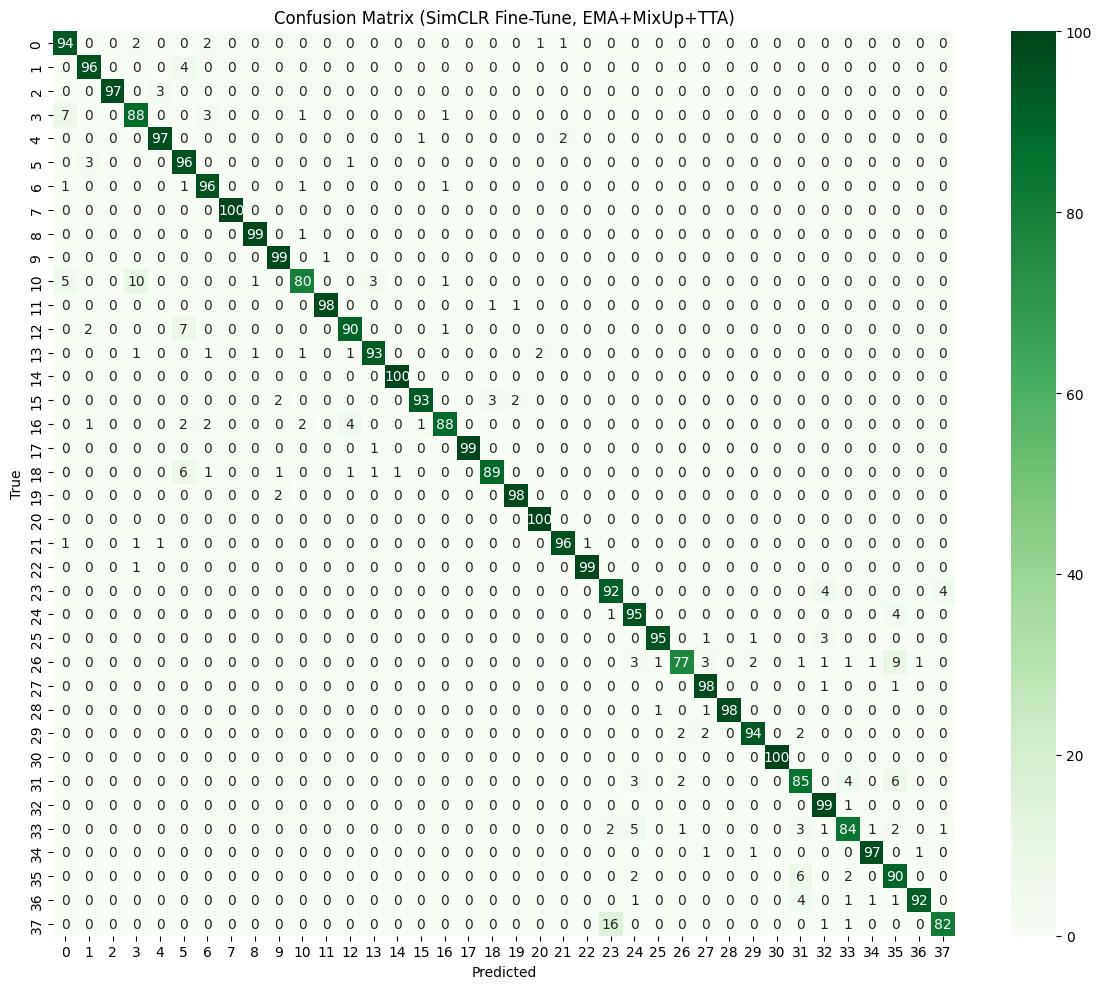

In [10]:
# === Part 9: Final evaluation on held-out 20% (EMA best) ===
finetune_encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
enc_path = os.path.join(SAVE_DIR, "simclr_encoder.pth")
best_path = os.path.join(SAVE_DIR, "simclr_finetune_best.pt")

finetune_encoder.load_state_dict(torch.load(enc_path, map_location=DEVICE))
sup_model = SupModel(finetune_encoder, num_classes).to(DEVICE)
sup_model.load_state_dict(torch.load(best_path, map_location=DEVICE))
sup_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader_sup:
        x = x.to(DEVICE, non_blocking=True)
        logits = (predict_tta(sup_model, x) if USE_TTA else sup_model(x))
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

print("\n=== SimCLR -> End-to-End Fine-Tune: Held-out Test ===")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (SimCLR Fine-Tune, EMA+MixUp+TTA)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "simclr_confusion_matrix.png"), dpi=150)
plt.show()


# Part 10 — Training Curves

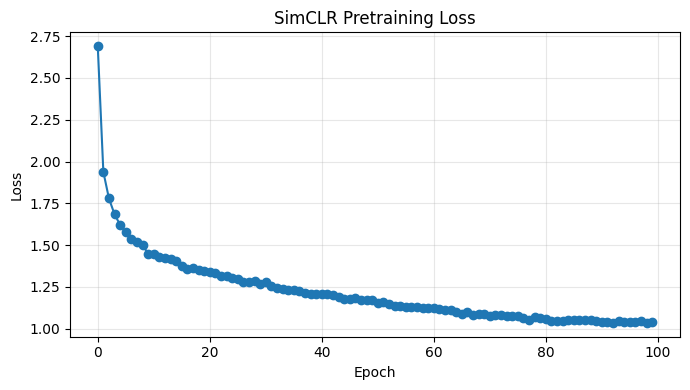

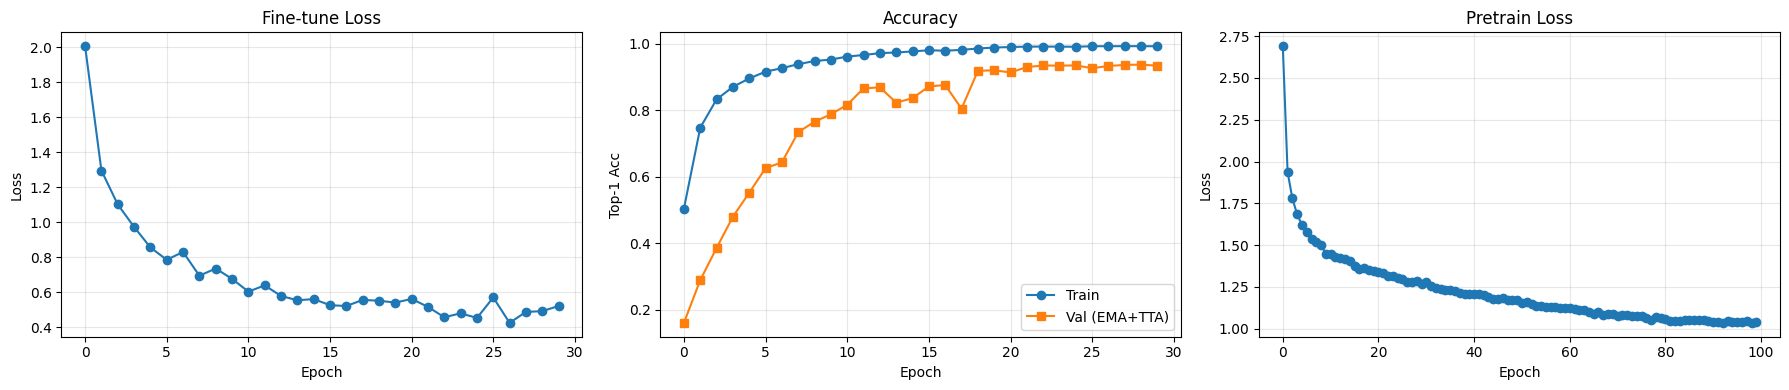

In [11]:
# === Part 10: Training Curves ===
plt.figure(figsize=(7,4))
plt.plot(simclr_loss_hist, marker='o')
plt.title("SimCLR Pretraining Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "simclr_pretrain_loss.png"), dpi=150)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18,4))
ax[0].plot(ft_loss_hist, marker='o')
ax[0].set_title("Fine-tune Loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].grid(True, alpha=0.3)

ax[1].plot(ft_acc_hist, marker='o', label='Train')
ax[1].plot(val_acc_hist, marker='s', label='Val (EMA+TTA)')
ax[1].set_title("Accuracy"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Top-1 Acc"); ax[1].grid(True, alpha=0.3); ax[1].legend()

ax[2].plot(simclr_loss_hist, marker='o')
ax[2].set_title("Pretrain Loss"); ax[2].set_xlabel("Epoch"); ax[2].set_ylabel("Loss"); ax[2].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(SAVE_DIR, "simclr_training_curves.png"), dpi=150)
plt.show()


# Part 11 — Collect predictions and probabilities (for CM & ROC/AUC)

In [12]:
# === Part 11: Gather predictions, probabilities, and class names ===
import numpy as np
import torch.nn.functional as F

sup_model.eval()
class_names = sup_test_ds.classes
num_classes = len(class_names)

all_probs, all_preds, all_targets = [], [], []

with torch.no_grad():
    for x, y in test_loader_sup:
        x = x.to(DEVICE, non_blocking=True)
        logits = (predict_tta(sup_model, x) if USE_TTA else sup_model(x))
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        preds  = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(y.numpy())

y_prob = np.concatenate(all_probs, axis=0)      # (N, C)
y_pred = np.concatenate(all_preds, axis=0)      # (N,)
y_true = np.concatenate(all_targets, axis=0)    # (N,)

print("Shapes -> y_prob:", y_prob.shape, "| y_pred:", y_pred.shape, "| y_true:", y_true.shape)
print("Classes:", class_names)


Shapes -> y_prob: (3800, 38) | y_pred: (3800,) | y_true: (3800,)
Classes: ['BD30', 'BD33', 'BD39', 'BD49', 'BD51', 'BD52', 'BD56', 'BD57', 'BD70', 'BD72', 'BD75', 'BD76', 'BD79', 'BD85', 'BD87', 'BD91', 'BD93', 'BD95', 'BR22', 'BR23', 'BRRI102', 'BRRI67', 'BRRI74', 'Binadhan10', 'Binadhan11', 'Binadhan12', 'Binadhan14', 'Binadhan16', 'Binadhan17', 'Binadhan19', 'Binadhan20', 'Binadhan21', 'Binadhan23', 'Binadhan24', 'Binadhan25', 'Binadhan26', 'Binadhan7', 'Binadhan8']


# Part 12 — Confusion Matrix (counts & normalized)

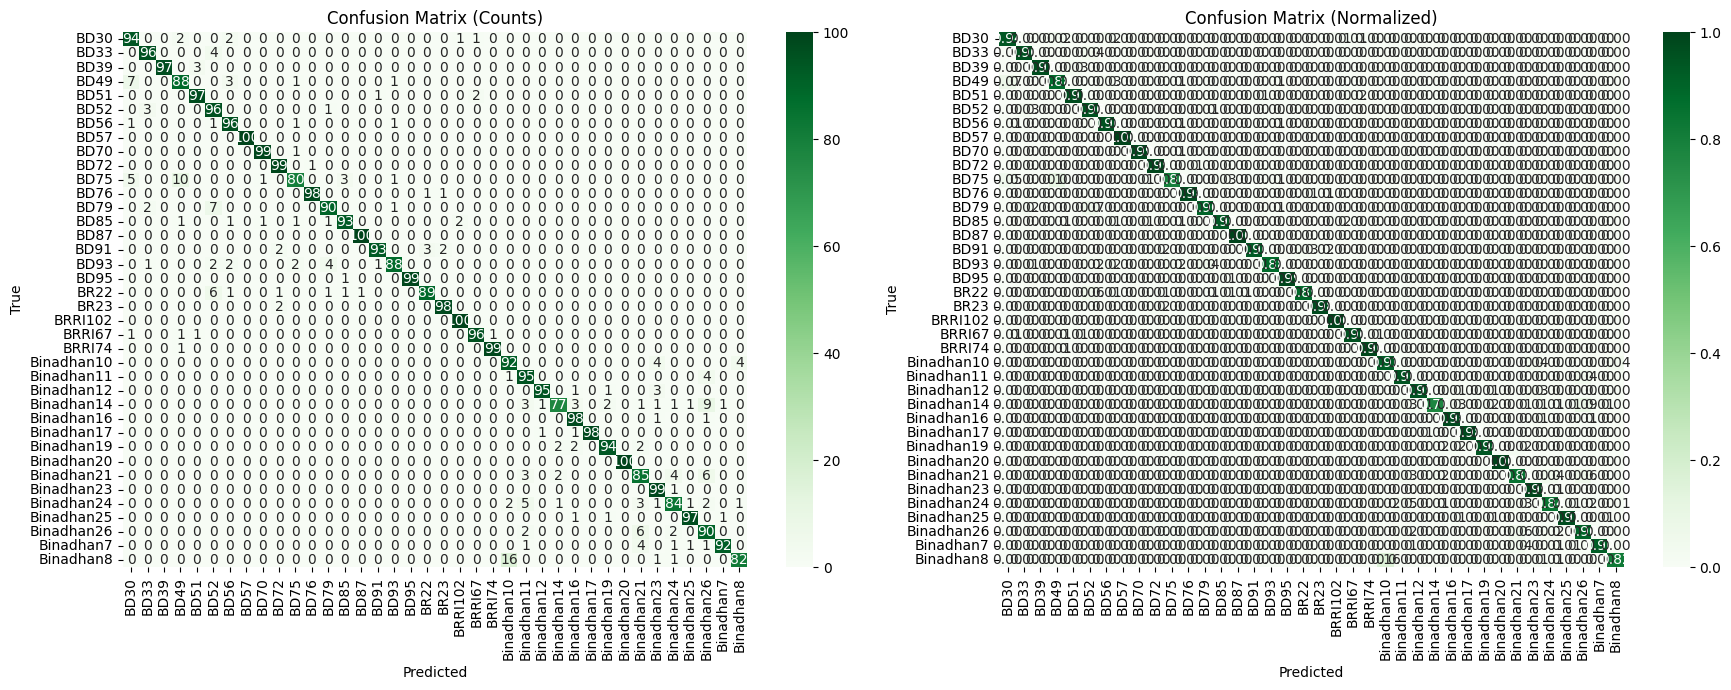

In [13]:
# === Part 12: Confusion Matrix (Counts & Normalized) ===
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix_counts_normalized.png"), dpi=150)
plt.show()


# Part 13 — ROC Curves & AUC (one-vs-rest, micro & macro)

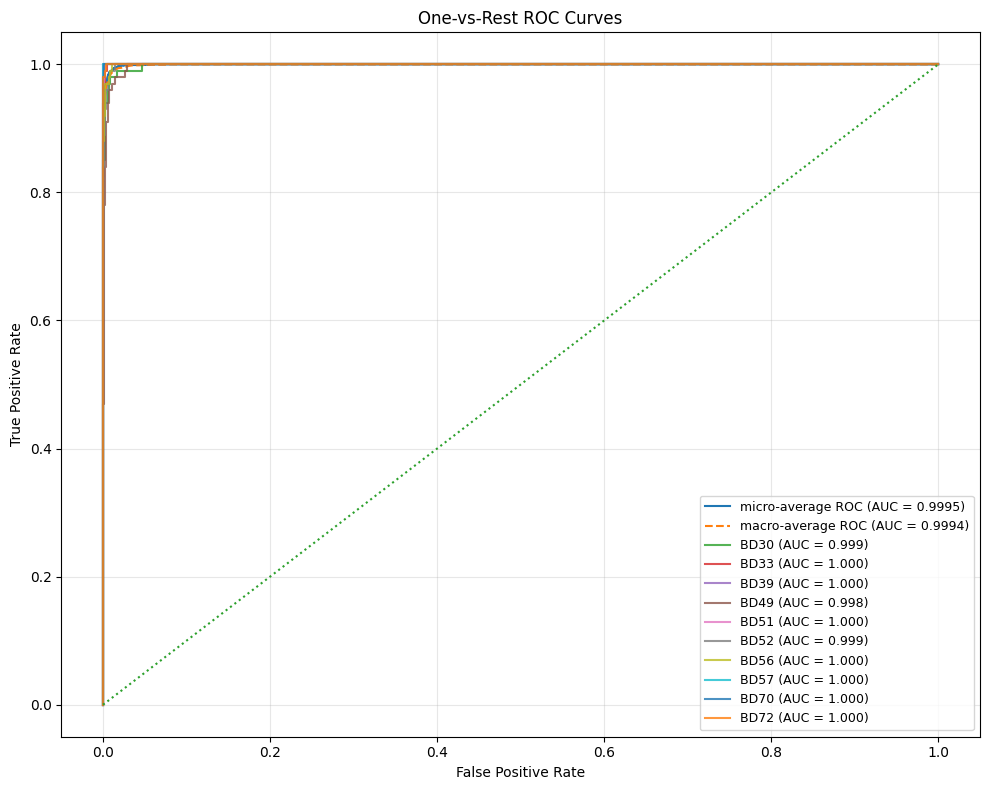

In [14]:
# === Part 13: ROC & AUC (One-vs-Rest, Micro, Macro) ===
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # (N, C)

fpr = dict(); tpr = dict(); roc_auc = dict()
for c in range(num_classes):
    fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_prob[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[c] for c in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], linestyle='-', label=f"micro-average ROC (AUC = {roc_auc['micro']:.4f})")
plt.plot(all_fpr,   mean_tpr,        linestyle='--', label=f"macro-average ROC (AUC = {roc_auc['macro']:.4f})")

max_shown = 10 if num_classes > 10 else num_classes
for c in range(max_shown):
    plt.plot(fpr[c], tpr[c], label=f"{class_names[c]} (AUC = {roc_auc[c]:.3f})", alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "roc_ovr_micro_macro.png"), dpi=150)
plt.show()


# Part 14 — Clustering of Features (K-Means, ARI/NMI, t-SNE viz)

K-Means on encoder features -> ARI: 0.6266 | NMI: 0.8146 | Silhouette: 0.1605
Running t-SNE (this can take ~30–60s on CPU for large N)...


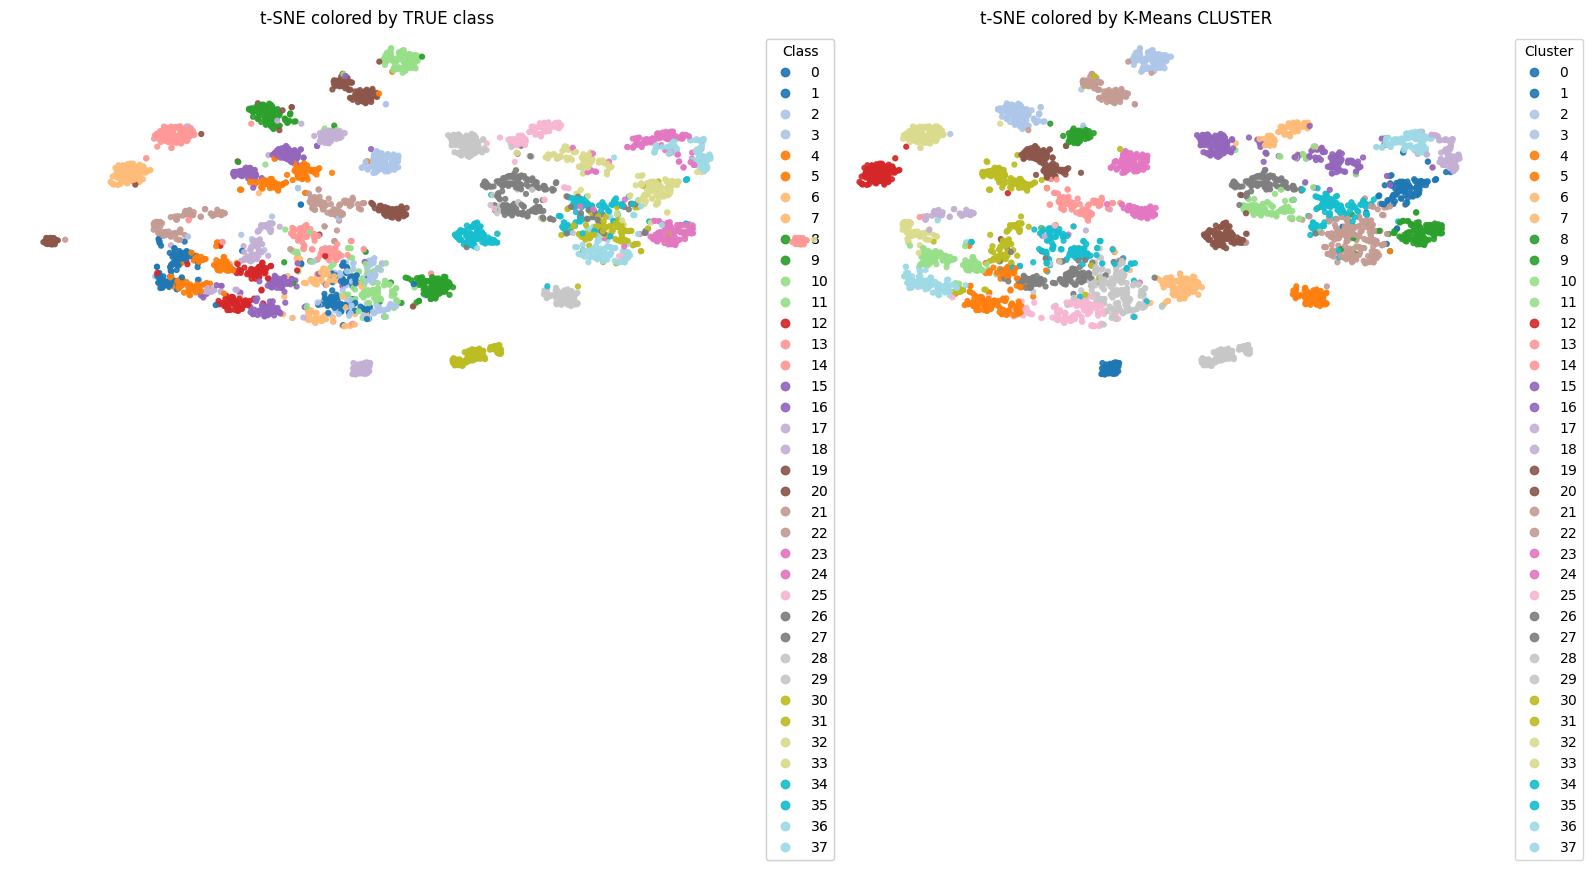

In [15]:
# === Part 14: Clustering on encoder features ===
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE

@torch.no_grad()
def extract_features_only(model, loader, device):
    model.eval()
    feats, labels = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        f = model.encoder(x)         # (B, 2048)
        feats.append(f.cpu().numpy()); labels.append(y.numpy())
    return np.concatenate(feats, 0), np.concatenate(labels, 0)

features, labels = extract_features_only(sup_model, test_loader_sup, DEVICE)
features_norm = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-9)

kmeans = KMeans(n_clusters=num_classes, n_init=20, random_state=SEED)
clusters = kmeans.fit_predict(features_norm)

ari = adjusted_rand_score(labels, clusters)
nmi = normalized_mutual_info_score(labels, clusters)
sil = silhouette_score(features_norm, clusters)
print(f"K-Means on encoder features -> ARI: {ari:.4f} | NMI: {nmi:.4f} | Silhouette: {sil:.4f}")

print("Running t-SNE (this can take ~30–60s on CPU for large N)...")
tsne = TSNE(n_components=2, perplexity=min(30, max(5, len(labels)//20)), init='pca', random_state=SEED)
emb2d = tsne.fit_transform(features_norm)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
scatter1 = axes[0].scatter(emb2d[:,0], emb2d[:,1], c=labels, s=12, alpha=0.9, cmap='tab20')
axes[0].set_title("t-SNE colored by TRUE class")
axes[0].axis('off')
legend1 = axes[0].legend(*scatter1.legend_elements(num=num_classes), title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].add_artist(legend1)

scatter2 = axes[1].scatter(emb2d[:,0], emb2d[:,1], c=clusters, s=12, alpha=0.9, cmap='tab20')
axes[1].set_title("t-SNE colored by K-Means CLUSTER")
axes[1].axis('off')
legend2 = axes[1].legend(*scatter2.legend_elements(num=num_classes), title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "tsne_true_vs_cluster.png"), dpi=150)
plt.show()


# Part 15 — Single-Image Validation Demo (path or random test sample)

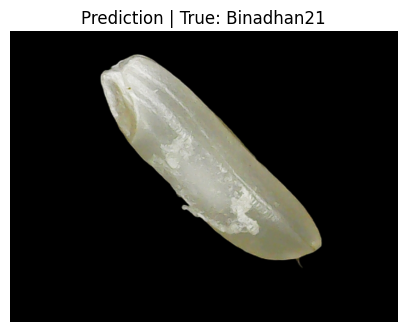

Top-k probabilities:
          Binadhan21: 0.8692
          Binadhan24: 0.0648
          Binadhan14: 0.0427
          Binadhan25: 0.0089
           Binadhan7: 0.0075


In [16]:
# === Part 15: Single Image Validation Demo ===
from PIL import Image
import torch
import numpy as np

img_path = None  # e.g., "/kaggle/input/riceds-original/Original/classX/img123.jpg"

if img_path is None:
    import random
    rnd_idx = random.choice(range(len(test_sup)))
    pil_img_transformed, true_label = test_sup[rnd_idx]
    raw_path, raw_lbl = sup_test_ds.samples[test_idx[rnd_idx]]
    rgb_img = Image.open(raw_path).convert("RGB")
    tensor_img = eval_tf(rgb_img).unsqueeze(0).to(DEVICE)
else:
    rgb_img = Image.open(img_path).convert("RGB")
    tensor_img = eval_tf(rgb_img).unsqueeze(0).to(DEVICE)
    true_label = None  # unknown unless from test set

sup_model.eval()
with torch.no_grad():
    logits = (predict_tta(sup_model, tensor_img) if USE_TTA else sup_model(tensor_img))
    probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()

topk = min(5, num_classes)
top_idx = np.argsort(-probs)[:topk]
top_pairs = [(class_names[i], float(probs[i])) for i in top_idx]

plt.figure(figsize=(5,5))
plt.imshow(rgb_img); plt.axis('off')
title = "Prediction"
if true_label is not None:
    title += f" | True: {class_names[true_label]}"
plt.title(title)
plt.show()

print("Top-k probabilities:")
for name, p in top_pairs:
    print(f"{name:>20s}: {p:.4f}")


# Part 16A — Grad-CAM per-class summary (recommended)

In [17]:
# === Part 16A: Grad-CAM per-class summary (correct & incorrect) ===
import os, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

OUT_DIR = os.path.join(SAVE_DIR, "gradcam_per_class")
os.makedirs(OUT_DIR, exist_ok=True)
N_PER_CLASS_CORRECT = 1
N_PER_CLASS_INCORRECT = 1

class GradCAM:
    def __init__(self, model: nn.Module, target_module: nn.Module):
        self.model = model
        self.target_module = target_module
        self.activations = None
        self.gradients = None
        self.fwd = target_module.register_forward_hook(self._fwd_hook)
        self.bwd = target_module.register_full_backward_hook(self._bwd_hook)
    def _fwd_hook(self, m, i, o): self.activations = o.detach()
    def _bwd_hook(self, m, gi, go): self.gradients = go[0].detach()
    def remove(self): self.fwd.remove(); self.bwd.remove()
    def generate(self, target_idx):
        w = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (w * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        B = cam.shape[0]
        cam = cam.view(B, -1); cam -= cam.min(dim=1, keepdim=True).values
        cam /= (cam.max(dim=1, keepdim=True).values + 1e-9)
        return cam.view(-1, 1, self.activations.shape[2], self.activations.shape[3])

def get_target_conv_module(sup_model: nn.Module, name='layer4'):
    return sup_model.encoder.backbone[7]  # ResNet50 layer4

def overlay_and_save(rgb_img, cam_upsampled, title, fpath):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(rgb_img); plt.axis('off'); plt.title(title)
    plt.subplot(1,2,2); plt.imshow(rgb_img); plt.imshow(cam_upsampled, cmap='jet', alpha=0.35); plt.axis('off'); plt.title("Grad-CAM")
    plt.tight_layout(); plt.savefig(fpath, dpi=150); plt.close()

# Pass 1: collect candidate indices per class
cands_correct = {c: [] for c in range(len(class_names))}
cands_incorrect = {c: [] for c in range(len(class_names))}

sup_model.eval()
test_samples = [sup_test_ds.samples[i] for i in test_idx]  # (path, label)

for idx_in_subset, (x_t, y_t) in enumerate(tqdm(test_loader_sup, desc="Scanning test set")):
    for j in range(x_t.size(0)):
        global_j = idx_in_subset * test_loader_sup.batch_size + j
        if global_j >= len(test_samples): break
        raw_path, true_lbl = test_samples[global_j]
        x = x_t[j:j+1].to(DEVICE, non_blocking=True)
        probs = F.softmax(sup_model(x), dim=1)[0].detach().cpu().numpy()
        pred = int(np.argmax(probs))
        conf = float(probs[pred])
        entry = (conf, raw_path, true_lbl, pred)
        if pred == true_lbl:
            cands_correct[true_lbl].append(entry)
        else:
            cands_incorrect[true_lbl].append(entry)

for c in range(len(class_names)):
    cands_correct[c].sort(key=lambda t: -t[0])
    cands_incorrect[c].sort(key=lambda t: -t[0])

# Pass 2: Grad-CAM overlays
target_module = get_target_conv_module(sup_model, 'layer4')
for c in range(len(class_names)):
    # Corrects
    for k, entry in enumerate(cands_correct[c][:N_PER_CLASS_CORRECT]):
        conf, raw_path, true_lbl, pred = entry
        rgb = Image.open(raw_path).convert("RGB")
        x = eval_tf(rgb).unsqueeze(0).to(DEVICE)
        cam_engine = GradCAM(sup_model, target_module)
        with torch.enable_grad():
            x.requires_grad_(True)
            logits = sup_model(x)
            score = logits[0, pred]
            sup_model.zero_grad(set_to_none=True)
            score.backward()
            cam = cam_engine.generate(pred)[0,0]
            cam_engine.remove()
        cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=x.shape[-2:], mode='bilinear', align_corners=False)[0,0].cpu().numpy()
        title = f"TRUE={class_names[true_lbl]} | PRED={class_names[pred]} ({conf:.3f}) [correct]"
        fpath = os.path.join(OUT_DIR, f"class{c:02d}_correct_{k}.png")
        overlay_and_save(rgb, cam_up, title, fpath)

    # Incorrects
    for k, entry in enumerate(cands_incorrect[c][:N_PER_CLASS_INCORRECT]):
        conf, raw_path, true_lbl, pred = entry
        rgb = Image.open(raw_path).convert("RGB")
        x = eval_tf(rgb).unsqueeze(0).to(DEVICE)
        cam_engine = GradCAM(sup_model, target_module)
        with torch.enable_grad():
            x.requires_grad_(True)
            logits = sup_model(x)
            score = logits[0, pred]
            sup_model.zero_grad(set_to_none=True)
            score.backward()
            cam = cam_engine.generate(pred)[0,0]
            cam_engine.remove()
        cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=x.shape[-2:], mode='bilinear', align_corners=False)[0,0].cpu().numpy()
        title = f"TRUE={class_names[true_lbl]} | PRED={class_names[pred]} ({conf:.3f}) [incorrect]"
        fpath = os.path.join(OUT_DIR, f"class{c:02d}_incorrect_{k}.png")
        overlay_and_save(rgb, cam_up, title, fpath)

print(f"Saved per-class Grad-CAM overlays to: {OUT_DIR}")


Scanning test set: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s]


Saved per-class Grad-CAM overlays to: ./gradcam_per_class
